<a href="https://colab.research.google.com/github/OmarChocamani/SIS420-OCL/blob/main/Copia_de_reg_log_onevsall_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

Se usa binary croos center para poder allar las titas en clasificacion multiclase y clasificacion binaria
y el descenso por el gradiente para regresiones lineales y multivariables

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np
import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# modulo para cargar archivos en formato MATLAB
# from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Clasificación multiclase

Para este ejercicio, se usará regresión logística y redes neuronales para reconocer dígitos escritos a mano (de 0 a 9). El reconocimiento automático de dígitos escritos a mano se usa ampliamente en la actualidad, desde el reconocimiento de códigos postales (códigos postales) en sobres de correo hasta el reconocimiento de montos escritos en cheques bancarios. Este ejercicio  mostrará cómo los métodos que ha aprendido se pueden utilizar para esta tarea de clasificación.

La primera parte del ejercicio, extenderá la implementación anterior de la regresión logística y la aplicará a la clasificación de uno contra todos (one vs all).

### 1.1 Dataset

Se proporciona un conjunto de datos en `ex3data1.mat` que contiene 5000 ejemplos de entrenamiento de dígitos escritos a mano (este es un subconjunto del conjunto de datos de dígitos escritos a mano [MNIST] http://yann.lecun.com/exdb/mnist)). El formato `.mat` significa que los datos se han guardado en un formato de matriz nativo Octave/MATLAB, en lugar de un formato de texto (ASCII) como un archivo csv. Usamos el formato `.mat` aquí para mostrar los diferentes formatos en los que se pueden presentar los datasets. Python proporciona mecanismos para cargar el formato nativo de MATLAB usando la función `loadmat` dentro del módulo` scipy.io`. Esta función devuelve un diccionario de Python con claves que contienen los nombres de las variables dentro del archivo `.mat`.

Hay 5000 ejemplos de entrenamiento en `ex3data1.mat`, donde cada ejemplo de entrenamiento es una imagen en escala de grises de 20 píxeles por 20 píxeles del dígito. Cada píxel está representado por un número de punto flotante que indica la intensidad de la escala de grises en esa ubicación. La cuadrícula de 20 por 20 píxeles se "desenrolla" en un vector de 400 dimensiones. Cada uno de estos ejemplos de entrenamiento se convierte en una sola fila en nuestra matriz de datos "X". Esto da una matriz `X` de 5000 por 400 donde cada fila es un ejemplo de entrenamiento para una imagen de dígitos escrita a mano.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

La segunda parte del conjunto de entrenamiento es un vector "y" de 5000 dimensiones que contiene etiquetas para el conjunto de entrenamiento.

Se inicia el ejercicio cargando primero el conjunto de datos.

In [4]:
data= pd.read_csv('/content/drive/MyDrive/SIS420/MiDataSets/gcar_data.csv')
#data.info()
#print(data)
#print(data)

In [5]:
#Se agragan las 3 columnas necesarias
# Crear una nueva columna que describe el estado basado en el kilometraje
data['estado'] = data['mileage_in_km'].apply(lambda x: 'Excelente' if x < 50000 else 'Usado')
# Crear una columna booleana indicando si el auto tiene transmisión automática
data['es_automatico'] = data['transmission_type'].apply(lambda x: True if x == 'Automático' else False)
# Crear una columna que combine la potencia y el tipo de combustible
data['descripcion_auto'] = data.apply(lambda row: f"{row['power_kw']} KW - {row['fuel_type']}", axis=1)
print(data)

       Unnamed: 0       brand                 model  color registration_date  \
0           75721        ford             Ford Kuga  black           05/2023   
1           80184     hyundai           Hyundai i10  black           09/2018   
2           19864        audi        Audi Q4 e-tron   grey           05/2021   
3           76699       honda            Honda CR-V    red           07/2018   
4           92991         kia          Kia Sportage  black           02/2023   
...           ...         ...                   ...    ...               ...   
99995        6265        audi               Audi A1   blue           05/2012   
99996       54886        fiat              Fiat 500  black           12/2019   
99997       76820       honda            Honda CR-V  brown           01/2019   
99998         860  alfa-romeo  Alfa Romeo Giulietta   grey           12/2020   
99999       15795        audi               Audi A3  black           05/2018   

       year price_in_euro power_kw powe

In [6]:
#data.info()

In [7]:
#Preprocesamiento de datos
#Ademas observaremos la cantidad e etiquetas que tendra
to_convert = ['brand']
id2label = {}
label2id = {}
for col in to_convert:
    id2label[col] = {i: cls for i, cls in enumerate(data[col].unique())}
    label2id[col] = {cls: i for i, cls in id2label[col].items()}
    data[col] = data[col].replace(label2id[col])
    print(label2id[col])

{'ford': 0, 'hyundai': 1, 'audi': 2, 'honda': 3, 'kia': 4, 'dacia': 5, 'bmw': 6, 'citroen': 7, 'alfa-romeo': 8, 'land-rover': 9, 'jaguar': 10, 'dodge': 11, 'fiat': 12, 'lamborghini': 13, 'mazda': 14, 'isuzu': 15, 'jeep': 16, 'ferrari': 17, 'bentley': 18, 'maserati': 19, 'daihatsu': 20, 'chevrolet': 21, 'aston-martin': 22, 'cadillac': 23, 'daewoo': 24, 'chrysler': 25, 'lancia': 26, 'lada': 27, 'infiniti': 28}


In [8]:
num_labels = 29

In [9]:
#variables categoricas
columnas_categoricas = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for columna in columnas_categoricas:
    data[columna] = le.fit_transform(data[columna]).astype(float)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  int64  
 1   brand                     100000 non-null  int64  
 2   model                     100000 non-null  float64
 3   color                     100000 non-null  float64
 4   registration_date         100000 non-null  float64
 5   year                      100000 non-null  float64
 6   price_in_euro             100000 non-null  float64
 7   power_kw                  100000 non-null  float64
 8   power_ps                  100000 non-null  float64
 9   transmission_type         100000 non-null  float64
 10  fuel_type                 100000 non-null  float64
 11  fuel_consumption_l_100km  100000 non-null  float64
 12  fuel_consumption_g_km     100000 non-null  float64
 13  mileage_in_km             99932 non-null   fl

In [12]:
data['es_automatico'] = data['es_automatico'].astype(float)
data['Unnamed: 0'] = data['Unnamed: 0'].astype(float)
data['brand'] = data['brand'].astype(float)

In [14]:
#print(data)
#data.info()


In [15]:
#llenar datos vacios
columnas_especificas = ['mileage_in_km']
media_columnas = data[columnas_especificas].mean()
data[columnas_especificas] = data[columnas_especificas].fillna(media_columnas)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  float64
 1   brand                     100000 non-null  float64
 2   model                     100000 non-null  float64
 3   color                     100000 non-null  float64
 4   registration_date         100000 non-null  float64
 5   year                      100000 non-null  float64
 6   price_in_euro             100000 non-null  float64
 7   power_kw                  100000 non-null  float64
 8   power_ps                  100000 non-null  float64
 9   transmission_type         100000 non-null  float64
 10  fuel_type                 100000 non-null  float64
 11  fuel_consumption_l_100km  100000 non-null  float64
 12  fuel_consumption_g_km     100000 non-null  float64
 13  mileage_in_km             100000 non-null  fl

In [16]:
data_copy = data.copy()

# Aumentar solo los valores decimales en el DataFrame duplicado
# Especificar las columnas numéricas en las que deseas aumentar los decimales
decimal_columns = ['Unnamed: 0','model','color','registration_date','year','price_in_euro','power_kw','power_ps','fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km','offer_description','descripcion_auto']

# Asegurarse de que las columnas sean del tipo adecuado
for col in decimal_columns:
    data_copy[col] = pd.to_numeric(data_copy[col], errors='coerce')

# Filtrar filas con valores no válidos (NaN) en columnas decimales
data_copy = data_copy.dropna(subset=decimal_columns)

# Aumentar los valores decimales en las columnas especificadas
for col in decimal_columns:
    data_copy[col] = data_copy[col] + np.random.uniform(0.1, 0.7, size=len(data_copy))


# Asegurarse de que los valores estén dentro de rangos razonables
for col in decimal_columns:
    data_copy[col] = data_copy[col].clip(lower=0)

# Concatenar los DataFrames originales y modificados
nuevo_data = pd.concat([data, data_copy], ignore_index=True)

# Guardar el dataset aumentado en un nuevo archivo CSV
nuevo_data.to_csv('ruta_del_archivo_modificado.csv', index=False)

# Ver las primeras filas del DataFrame aumentado
#print(nuevo_data.head())

In [17]:
print(nuevo_data.iloc[150000])

Unnamed: 0                  85797.150575
brand                          10.000000
model                         483.286469
color                           7.291169
registration_date              86.122042
year                           38.225728
price_in_euro                7983.102429
power_kw                       61.473407
power_ps                       92.345010
transmission_type               0.000000
fuel_type                      42.398183
fuel_consumption_l_100km      229.538701
fuel_consumption_g_km          50.260392
mileage_in_km                1100.190515
offer_description           38656.421799
estado                          0.000000
es_automatico                   0.000000
descripcion_auto              187.571154
Name: 150000, dtype: float64


In [18]:
nuevo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                200000 non-null  float64
 1   brand                     200000 non-null  float64
 2   model                     200000 non-null  float64
 3   color                     200000 non-null  float64
 4   registration_date         200000 non-null  float64
 5   year                      200000 non-null  float64
 6   price_in_euro             200000 non-null  float64
 7   power_kw                  200000 non-null  float64
 8   power_ps                  200000 non-null  float64
 9   transmission_type         200000 non-null  float64
 10  fuel_type                 200000 non-null  float64
 11  fuel_consumption_l_100km  200000 non-null  float64
 12  fuel_consumption_g_km     200000 non-null  float64
 13  mileage_in_km             200000 non-null  f

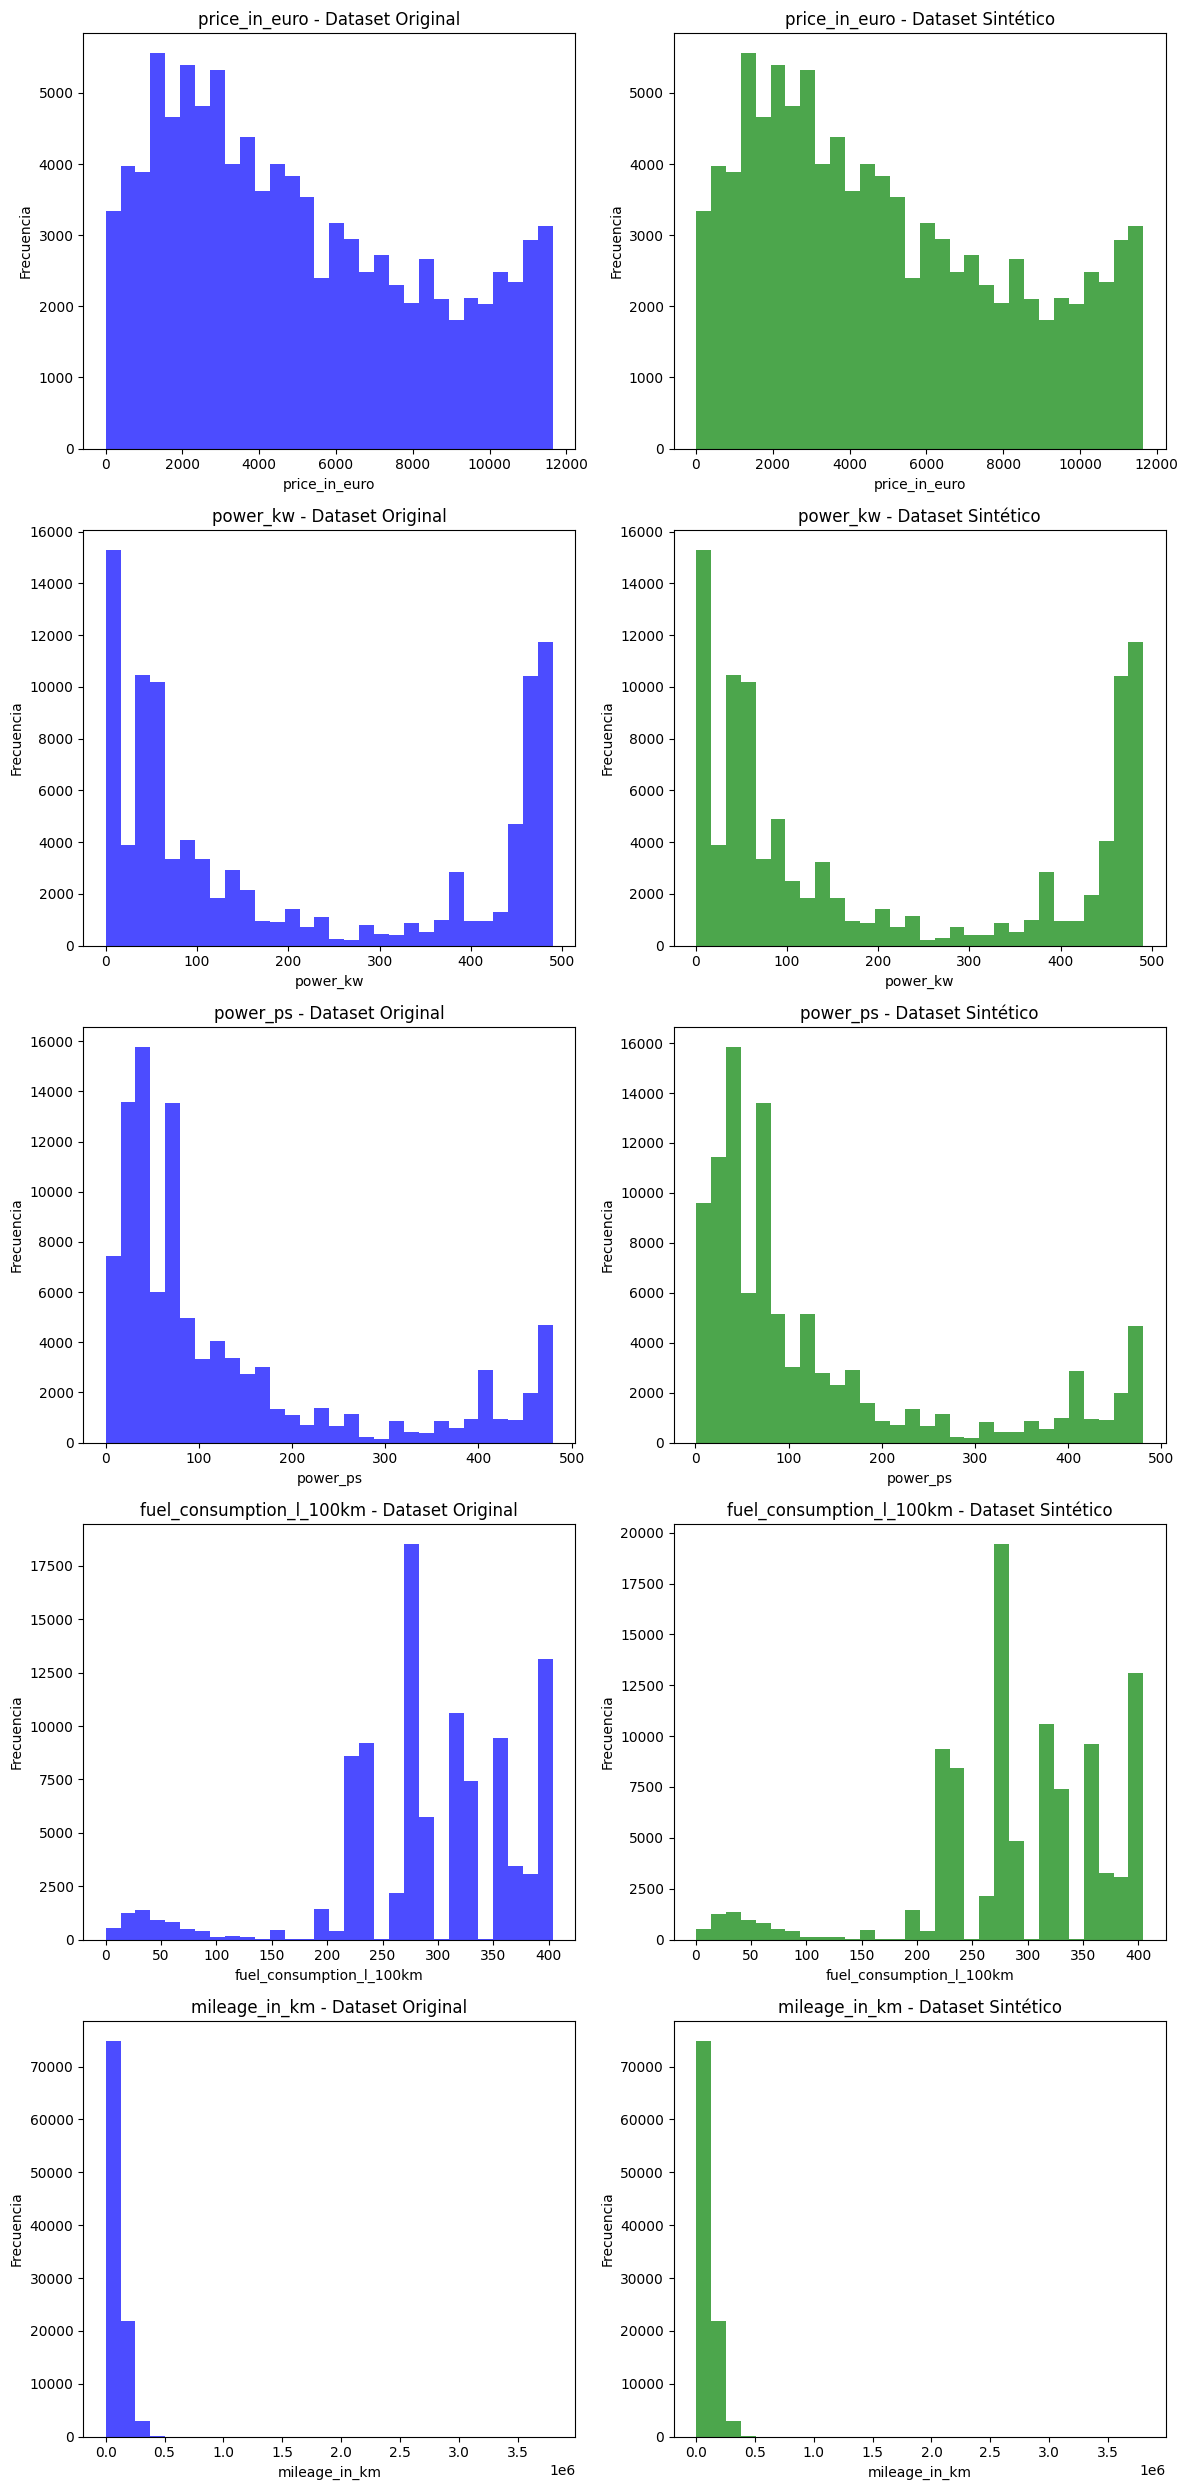

In [19]:
# Cargar los datasets originales y sintéticos
#data_original = pd.read_csv('ruta_del_archivo_original.csv')
#data_sintetico = pd.read_csv('ruta_del_archivo_modificado.csv')

# Especificar las columnas numéricas que queremos graficar
columnas_numericas = ['price_in_euro', 'power_kw', 'power_ps', 'fuel_consumption_l_100km', 'mileage_in_km']

# Crear una figura para comparar cada atributo entre los datasets
fig, axs = pyplot.subplots(len(columnas_numericas), 2, figsize=(12, 5 * len(columnas_numericas)))

# Iterar sobre las columnas numéricas y generar gráficos
for i, col in enumerate(columnas_numericas):
    # Graficar el dataset original
    axs[i, 0].hist(data[col].dropna(), bins=30, color='blue', alpha=0.7)
    axs[i, 0].set_title(f'{col} - Dataset Original')
    axs[i, 0].set_xlabel(col)
    axs[i, 0].set_ylabel('Frecuencia')

    # Graficar el dataset sintético
    axs[i, 1].hist(data_copy[col].dropna(), bins=30, color='green', alpha=0.7)
    axs[i, 1].set_title(f'{col} - Dataset Sintético')
    axs[i, 1].set_xlabel(col)
    axs[i, 1].set_ylabel('Frecuencia')

# Ajustar el espacio entre gráficos
pyplot.tight_layout()
pyplot.show()


In [20]:
X_datos=nuevo_data.iloc[:,[2,3,4,5,6,7,8,9,10,11,12,13,14]]
y_datos=nuevo_data.iloc[:,1]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_datos, y_datos, test_size=0.2)
X_train.shape, X_test.shape

((160000, 13), (40000, 13))

In [22]:
X=X_train
y=y_train
print(y)

147818    1.0
144948    0.0
51756     1.0
130499    6.0
144255    4.0
         ... 
8651      2.0
98072     9.0
159985    2.0
42306     2.0
184608    6.0
Name: brand, Length: 160000, dtype: float64


In [23]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [24]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

In [25]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
# X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
X = X_norm
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

### 1.2 Visualización de los datos

Se comenzará visualizando un subconjunto del conjunto de entrenamiento. Se selecciona al azar, 100 filas de `X` y pasa esas filas a la función` displayData`. Esta función asigna cada fila a una imagen en escala de grises de 20 píxeles por 20 píxeles y muestra las imágenes juntas.

### 1.3 Vectorización de regresión logística

Se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 10 clases, deberá entrenar 10 clasificadores de regresión logística separados. Para que esta capacitación sea eficiente, es importante asegurarse de que el código esté bien vectorizado.

En esta sección, se implementará una versión vectorizada de regresión logística que no emplea ningún bucle "for".

Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

<a id="section1"></a>
#### 1.3.1 Vectorización de la funcion de costo

Se inicia escribiendo una versión vectorizada de la función de costo. En la regresión logística (no regularizada), la función de costo es

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

Para calcular cada elemento en la suma, tenemos que calcular $h_\theta(x^{(i)})$ para cada ejemplo $i$, donde $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ y $g(z) = \frac{1}{1+e^{-z}}$ es la funcion sigmoidea. Resulta que podemos calcular esto rápidamente para todos los ejemplos usando la multiplicación de matrices. Definamos $X$ y $\theta$ como

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Luego, de calcular el producto matricial $X\theta$, se tiene:

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

En la última igualdad, usamos el hecho de que $a^Tb = b^Ta$ if $a$ y $b$ son vectores. Esto permite calcular los productos $\theta^T x^{(i)}$ para todos los ejemplos $i$ en una linea de codigo.

#### 1.3.2 Vectorización del gradiente

Recordemos que el gradiente del costo de regresión logística (no regularizado) es un vector donde el elemento $j^{th}$ se define como
$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

Para vectorizar esta operación sobre el conjunto de datos, se inicia escribiendo todas las derivadas parciales explícitamente para todos $\theta_j$,

$$
\begin{align*}
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

donde

$$  h_\theta(x) - y =
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)}
\end{bmatrix} $$

Nota $x^{(i)}$ es un vector, mientras $h_\theta\left(x^{(i)}\right) - y^{(i)}$ es un escalar(simple número).
Para comprender el último paso de la derivación, dejemos $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ y
observar que:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

donde los valores $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

La expresión anterior nos permite calcular todas las derivadas parciales sin bucles.
Si se siente cómodo con el álgebra lineal, le recomendamos que trabaje con las multiplicaciones de matrices anteriores para convencerse de que la versión vectorizada hace los mismos cálculos.

<div class="alert alert-box alert-warning">
** Consejo de depuración: ** El código de vectorización a veces puede ser complicado. Una estrategia común para la depuración es imprimir los tamaños de las matrices con las que está trabajando usando la propiedad `shape` de las matrices` numpy`.

Por ejemplo, dada una matriz de datos $X$ de tamaño $100\veces 20$ (100 ejemplos, 20 características) y $\theta$, un vector con tamaño $20$, puede observar que `np.dot (X, theta) `es una operación de multiplicación válida, mientras que` np.dot (theta, X) `no lo es.

Además, si tiene una versión no vectorizada de su código, puede comparar la salida de su código vectorizado y el código no vectorizado para asegurarse de que produzcan las mismas salidas.</div>
<a id="lrCostFunction"></a>

In [26]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [68]:
J_history=[]
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
#     alpha = 0.003
#     theta = theta.copy()
    # Inicializa algunos valores utiles
    global J_history

    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

#     J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
#     theta = theta - (alpha / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    J_history.append(J)

    return J, grad
#    return J, theta


#### 1.3.3 Vectorización regularizada de la regresión logística

Una vez implementada la vectorización para la regresión logística, corresponde agregarar regularización a la función de costo.
Para la regresión logística regularizada, la función de costo se define como

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Tomar en cuenta que no debería regularizarse $\theta_0$ que se usa para el término de sesgo. En consecuencia, la derivada parcial del costo de regresión logística regularizado para $\theta_j$ se define como

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

<div class="alert alert-box alert-warning">
** Python/numpy Consejo: ** Al implementar la vectorización para la regresión logística regularizada, a menudo es posible que solo desee sumar y actualizar ciertos elementos de $\theta$. En `numpy`, puede indexar en las matrices para acceder y actualizar solo ciertos elementos.

Por ejemplo, A [:, 3: 5] = B [:, 1: 3] reemplazará las columnas con índice 3 a 5 de A con las columnas con índice 1 a 3 de B.   
Para seleccionar columnas (o filas) hasta el final de la matriz, puede dejar el lado derecho de los dos puntos en blanco.
Por ejemplo, A [:, 2:] solo devolverá elementos desde $3^{rd}$ a las últimas columnas de $A$.Si deja el tamaño de la mano izquierda de los dos puntos en blanco, seleccionará los elementos del principio de la matriz.
Por ejemplo, A [:,: 2] selecciona las dos primeras columnas y es equivalente a A [:, 0: 2]. Además, puede utilizar índices negativos para indexar matrices desde el final.
Por lo tanto, A [:,: -1] selecciona todas las columnas de A excepto la última columna, y A [:, -5:] selecciona la columna $5^{th}$ desde el final hasta la última columna.

Por lo tanto, podría usar esto junto con las operaciones de suma y potencia ($^{**}$) para calcular la suma de solo los elementos que le interesan (por ejemplo, `np.sum (z[1:]**2)`).
</div>


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all
En esta parte del ejercicio, se implementará la clasificación de uno contra todos mediante el entrenamiento de múltiples clasificadores de regresión logística regularizados, uno para cada una de las clases $K$ en nuestro conjunto de datos. En el conjunto de datos de dígitos escritos a mano, $K = 10$, pero su código debería funcionar para cualquier valor de $K$.

El argumento `y` de esta función es un vector de etiquetas de 0 a 9. Al entrenar el clasificador para la clase $k \in \{0, ..., K-1 \} $, querrá un vector K-dimensional de etiquetas $y$, donde $y_j \ in 0, 1$ indica si la instancia de entrenamiento $j ^ {th}$ pertenece a la clase $k$ $(y_j = 1)$, o si pertenece a una clase diferente $(y_j = 0)$.

Además, se utiliza `optimize.minimize` de scipy para este ejercicio.
<a id="oneVsAll"></a>

In [ ]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles

    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))



    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        print(f"Entrenando para la clase {c}...")
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[c] = res.x


    return all_theta

In [84]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

Entrenando para la clase 0...
Entrenando para la clase 1...
Entrenando para la clase 2...
Entrenando para la clase 3...
Entrenando para la clase 4...
Entrenando para la clase 5...
Entrenando para la clase 6...
Entrenando para la clase 7...
Entrenando para la clase 8...
Entrenando para la clase 9...
Entrenando para la clase 10...
Entrenando para la clase 11...
Entrenando para la clase 12...
Entrenando para la clase 13...
Entrenando para la clase 14...
Entrenando para la clase 15...
Entrenando para la clase 16...
Entrenando para la clase 17...
Entrenando para la clase 18...
Entrenando para la clase 19...
Entrenando para la clase 20...
Entrenando para la clase 21...
Entrenando para la clase 22...
Entrenando para la clase 23...
Entrenando para la clase 24...
Entrenando para la clase 25...
Entrenando para la clase 26...
Entrenando para la clase 27...
Entrenando para la clase 28...


ValueError: shapes (160000,15) and (14,29) not aligned: 15 (dim 1) != 14 (dim 0)

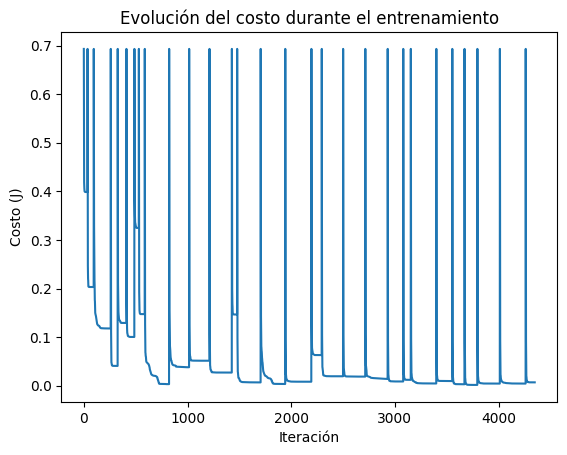

In [72]:
pyplot.plot(J_history)
pyplot.xlabel('Iteración')
pyplot.ylabel('Costo (J)')
pyplot.title('Evolución del costo durante el entrenamiento')
pyplot.show()

In [30]:
print(all_theta)

[[-1.88745740e+00  1.02499159e+00  1.34132033e-01  1.39125656e-02
  -1.25214766e-01  6.36008804e-02  1.19655901e-01 -3.54959123e-01
   4.93790715e-01 -1.41604906e-01 -3.34803255e-02  8.15768082e-02
   4.46480259e-02  7.30376884e-02]
 [-3.60707704e+00  1.48267865e+00  5.96077493e-02  4.30813259e-02
   2.83930607e-01 -8.75356678e-02  8.94863413e-02  9.85687036e-04
   1.49356888e-01  2.47284028e-01  1.10588498e-01 -2.43638394e-01
  -2.44472597e-02 -6.93402488e-02]
 [-1.31824932e+01 -1.21753263e+01  8.48197786e-02 -7.35509257e-02
   4.01014362e-01 -1.44070348e-01 -1.99555477e-02  5.10903913e-01
  -2.08446406e-01 -1.18668023e-01  3.46929648e-01  1.72773537e-01
   3.30457782e-01 -4.35264102e-01]
 [-5.65702703e+00  8.44793117e-01 -1.22671416e-01  2.45930094e-02
   1.01061859e-01 -1.81360248e-01 -4.76066998e-02 -4.79490570e-01
   1.58445224e-03  3.66342229e-01  1.03779186e-01  9.09172900e-02
  -2.73143725e-01 -5.70403682e-01]
 [-6.63206515e+00  3.65033404e+00  1.13860805e-01  1.19351109e-01
  

<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados. La función de predicción one-vs-all seleccionará la clase para la cual el clasificador de regresión logística correspondiente genera la probabilidad más alta y devolverá la etiqueta de clase (0, 1, ..., K-1) como la predicción para el ejemplo de entrada.

In [31]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p



Una vez que haya terminado, se llama a la función `predictOneVsAll` usando el valor aprendido de $\theta$. Debería apreciarse que la precisión del conjunto de entrenamiento es de aproximadamente 95,1% (es decir, clasifica correctamente el 95,1% de los ejemplos del conjunto de entrenamiento).

In [77]:
X_Nor_test, mu, sigma = featureNormalize(X_test)
#print(X_Nor_test)

pred = predictOneVsAll(all_theta, X_Nor_test)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y_test) * 100))

#num_epochs = 50
#precisions = []

# Selecciona las primeras 150 filas de X
XPrueba = X_Nor_test.iloc[0:150, :].copy()
#XPrueba = np.concatenate([np.ones((150, 1)), XPrueba], axis=1)
#print(XPrueba[0])
#for epoch in range(num_epochs):
p = predictOneVsAll(all_theta, XPrueba)
#precision = np.mean(pred == y_test) * 100
#precisions.append(precision)
#print(XPrueba[0])
#p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis=1)

print("Predicciones")
print(p)

# Muestra los datos reales de prueba
print("Datos reales de prueba")
print(y_test[0:150])

Precision del conjuto de entrenamiento: 68.31%
Predicciones
[ 0  4  0 12  0  2  0  0  9  6  0  0  0  0  2  0  0  0 12  7  0  0  6  2
  0  0  0  2  2  5  2  0  6  6  6  6  0  2  6  0  5 14  6  6  6 17  2  0
  2  6  2  0  6  2  0  0  0  2  0  0  0  0  0  6  4  0  0  2  2  6  6  2
 12  9  0  0  4  2 14  6  0  2  6  0  0  2  6  0  0  0  0  0  0  2  2  6
  0  0  0  2  2 19  0 16 12  2  0  2  2  0  6  0  2 14  2  0 19  2  0  2
  6  0  0  0  0 12  0  6  0  0  0  0  0  0  7  0  2  2  9  0  0  6  0  2
  2  2  0  0  0  4]
Datos reales de prueba
91417     12.0
197753     4.0
99187      0.0
25508      4.0
53176      0.0
          ... 
180508     2.0
184247     0.0
104140     4.0
147108     3.0
72033      9.0
Name: brand, Length: 150, dtype: float64


In [78]:
print(precisions)

[68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31, 68.31]


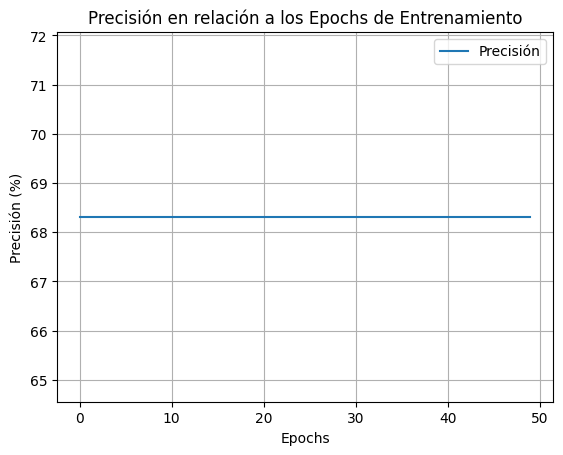

In [79]:
pyplot.plot(precisions, label='Precisión')
pyplot.xlabel('Epochs')
pyplot.ylabel('Precisión (%)')
pyplot.title('Precisión en relación a los Epochs de Entrenamiento')
pyplot.legend()
pyplot.grid()
pyplot.show()